In [ ]:
# Mount Google Drive (optional, if you need to save/load data)
from google.colab import drive
drive.mount('/content/drive')

# Define file path
f_path = '/content/drive/MyDrive/DiTing2.0/'

!pip install deepwave

Mounted at /content/drive
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.4/16.4 MB 15.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 112.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 88.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 46.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 39.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 18.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
import datetime

import pickle
import numpy as np

In [ ]:
#@title Generate random velocity model

class SeismicConfig:
    """Configuration class for seismic modeling"""
    def __init__(
        self,
        model_dims=(128, 128, 128),
        v0: float = 1500.0,  # Background velocity
        v_min: float = 1500.0,  # Minimum velocity
        v_max: float = 4500.0,  # Maximum velocity
        dv: float = 500.0,  # Velocity variation
    ):
        self.model_dims = model_dims
        self.v0 = v0
        self.v_min = v_min
        self.v_max = v_max
        self.dv = dv

def create_velocity_model(
    cfg: SeismicConfig,
    device: torch.device,
    seed: int = None):
    """
    Generates 3D velocity model with realistic geological features

    Features:
    - Horizon layers with natural undulations
    - Curved layers with varying thickness
    - Complex salt bodies

    Args:
        cfg: Configuration object containing model parameters
        device: Computation device (CPU/GPU)
        seed: Random seed for reproducibility (default: None)

    Returns:
        3D velocity tensor with shape (nx, ny, nz)
    """
    # Set random seed if provided
    if seed is not None:
        torch.manual_seed(seed)
        np.random.seed(seed)

    nx, ny, nz = cfg.model_dims

    # Initialize base velocity model
    velocity = torch.full(cfg.model_dims, cfg.v0, device=device)

    # Create coordinate grids
    X, Y, Z = torch.meshgrid(
        torch.arange(nx, device=device),
        torch.arange(ny, device=device),
        torch.arange(nz, device=device),
        indexing='ij'
    )

    # Generate horizon layers with undulations
    num_layers = torch.randint(4, 8, (1,)).item()
    for i in range(num_layers):
        # Layer depth function with undulations
        depth_base = (i + 1) * nz // (num_layers + 1)

        # Add undulations using combination of sine waves
        undulation = (
            10 * torch.sin(2 * np.pi * X[:,:,0] / nx * torch.rand(1, device=device)) +
            10 * torch.cos(2 * np.pi * Y[:,:,0] / ny * torch.rand(1, device=device)) +
            5 * torch.sin(4 * np.pi * (X[:,:,0] + Y[:,:,0]) / (nx + ny))
        )

        # Add curved component
        curve = 0.1 * ((X[:,:,0] - nx/2)**2 + (Y[:,:,0] - ny/2)**2) / (nx * ny)

        # Create layer depth map (2D)
        layer_depth = depth_base + undulation + curve

        # Create 3D layer mask
        base_vel = 2000 + i * 200 + torch.randn(1, device=device) * 100

        for i_x in range(nx):
            for i_y in range(ny):
                depth = int(layer_depth[i_x, i_y].item())
                if depth < nz:  # Ensure depth is within bounds
                    velocity[i_x, i_y, depth:] = base_vel

    # Add salt bodies with complex shapes
    num_salt = torch.randint(1, 3, (1,)).item()
    for _ in range(num_salt):
        # Salt body center and dimensions
        x0 = torch.randint(nx//4, 3*nx//4, (1,), device=device).item()
        y0 = torch.randint(ny//4, 3*ny//4, (1,), device=device).item()
        z0 = torch.randint(nz//3, 2*nz//3, (1,), device=device).item()

        rx = torch.randint(10, max(11, nx//5), (1,), device=device).item()
        ry = torch.randint(10, max(11, ny//5), (1,), device=device).item()
        rz = torch.randint(10, max(11, nz//5), (1,), device=device).item()

        # Create salt body with basic ellipsoidal shape
        salt_mask = ((X - x0)**2/rx**2 + (Y - y0)**2/ry**2 + (Z - z0)**2/rz**2) < 1.0

        # Set salt velocity (typically around 4500 m/s)
        velocity[salt_mask] = 4500 + torch.randn(1, device=device) * 100

    # Ensure velocity is within realistic bounds
    return torch.clamp(velocity, cfg.v_min, cfg.v_max)



# Create configuration
cfg = SeismicConfig(
    model_dims=(300, 300, 300),
    v0=1500.0,
    v_min=1500.0,
    v_max=4500.0,
    dv=500.0
)

# Generate velocity model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# velocity_model = create_velocity_model(cfg, device, 0) # [128,128,128]


In [ ]:
#@title Coresponding gravity field construction CPU
def create_gravity_3D_model_cpu(
    velocity_model: torch.Tensor,
    density_velocity_relation: str = 'gardner',
    noise_level: float = 0.05,
    gravity_constant: float = 6.67430e-11,  # 万有引力常数 (m^3 kg^-1 s^-2)
    device: torch.device = None
) -> torch.Tensor:
    """
    Creates a gravity model based on a velocity model.

    The function first converts velocity to density using empirical relationships,
    then computes the gravity field caused by the density distribution.

    Args:
        velocity_model: 3D velocity tensor with shape (nx, ny, nz)
        density_velocity_relation: Method to convert velocity to density ('gardner', 'linear', 'custom')
        noise_level: Amount of noise to add to the gravity model (0-1)
        gravity_constant: Gravitational constant
        device: Computation device (CPU/GPU)

    Returns:
        3D gravity tensor with the same shape as velocity_model
    """
    if device is None:
        device = velocity_model.device

    # Get dimensions
    nx, ny, nz = velocity_model.shape

    # Step 1: Convert velocity to density using empirical relationships
    if density_velocity_relation == 'gardner':
        # Gardner's relation: ρ = a * v^b, where a=0.31 and b=0.25 when v is in m/s and ρ in g/cm^3
        a = 0.31
        b = 0.25
        density = a * (velocity_model ** b)
    elif density_velocity_relation == 'linear':
        # Simple linear relationship: higher velocity generally means higher density
        v_min = velocity_model.min()
        v_max = velocity_model.max()
        density = (velocity_model - v_min) / (v_max - v_min) * 2.0 + 1.0  # Scale to 1.0-3.0 g/cm^3
    elif density_velocity_relation == 'custom':
        # More complex relationship with different behavior for different velocity ranges
        density = torch.zeros_like(velocity_model)

        # For sedimentary rocks (lower velocities)
        sediment_mask = velocity_model < 3000
        density[sediment_mask] = 1.0 + (velocity_model[sediment_mask] / 3000) * 1.7

        # For crystalline/igneous rocks (higher velocities)
        igneous_mask = ~sediment_mask
        density[igneous_mask] = 2.7 + (velocity_model[igneous_mask] - 3000) / 1500 * 0.3
    else:
        raise ValueError(f"Unknown density-velocity relation: {density_velocity_relation}")

    # Step 2: Compute gravity field from density distribution
    # For simplicity and computational efficiency, we'll use a simplified approach:
    # - Apply 3D convolution with a 1/r^2 kernel to simulate gravity field
    # - Add geological constraints to make it realistic

    # Create a distance kernel for gravity calculation
    kernel_size = min(31, min(nx, ny, nz) // 2 * 2 - 1)  # Odd number for kernel
    half_size = kernel_size // 2

    # Create coordinate grids for kernel
    kx, ky, kz = torch.meshgrid(
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        indexing='ij'
    )

    # Compute distance from center (avoid division by zero)
    r = torch.sqrt(kx**2 + ky**2 + kz**2 + 1e-10)

    # Gravity kernel (proportional to 1/r^2)
    gravity_kernel = 1.0 / (r**2)
    gravity_kernel[half_size, half_size, half_size] = 0  # Zero at center

    # Normalize kernel
    gravity_kernel = gravity_kernel / gravity_kernel.sum()

    # Reshape kernel for PyTorch convolution
    gravity_kernel = gravity_kernel.view(1, 1, kernel_size, kernel_size, kernel_size)

    # Apply 3D convolution to simulate gravity field
    # We need to pad the density tensor and use groups for 3D convolution
    padding = half_size

    # Convert density to 5D tensor for conv3d
    density_5d = density.view(1, 1, nx, ny, nz)

    # Use custom implementation for 3D convolution since PyTorch's conv3d expects different dimensions
    gravity_field = torch.zeros_like(density)

    # Simplified convolution approach - we'll use a smaller kernel and apply it directly
    # This is a simplified approach for demonstration; a real implementation would use a more efficient method
    for i in range(nx):
        for j in range(ny):
            for k in range(nz):
                # Extract neighborhood around current point
                i_min = max(0, i - half_size)
                i_max = min(nx, i + half_size + 1)
                j_min = max(0, j - half_size)
                j_max = min(ny, j + half_size + 1)
                k_min = max(0, k - half_size)
                k_max = min(nz, k + half_size + 1)

                # Extract corresponding kernel indices
                ki_min = half_size - (i - i_min)
                ki_max = half_size + (i_max - i)
                kj_min = half_size - (j - j_min)
                kj_max = half_size + (j_max - j)
                kk_min = half_size - (k - k_min)
                kk_max = half_size + (k_max - k)

                # Get neighborhood and kernel slice
                neighborhood = density[i_min:i_max, j_min:j_max, k_min:k_max]
                kernel_slice = gravity_kernel[0, 0, ki_min:ki_max, kj_min:kj_max, kk_min:kk_max]

                # Compute gravity at this point
                gravity_field[i, j, k] = (neighborhood * kernel_slice).sum() * gravity_constant

    # Step 3: Add realistic geological features and noise

    # Add regional trend (gravity typically increases with depth due to isostasy)
    depth_trend = torch.linspace(0, 1, nz, device=device)
    regional_trend = depth_trend.view(1, 1, nz).expand(nx, ny, nz) * 0.2 * gravity_field.mean()
    gravity_field = gravity_field + regional_trend

    # Add some lateral variations to simulate crustal thickness changes
    x_coords = torch.linspace(0, 1, nx, device=device)
    y_coords = torch.linspace(0, 1, ny, device=device)
    X, Y = torch.meshgrid(x_coords, y_coords, indexing='ij')
    lateral_variation = torch.sin(2 * np.pi * X * 2) * torch.cos(2 * np.pi * Y * 2) * 0.1 * gravity_field.mean()
    lateral_variation = lateral_variation.unsqueeze(-1).expand(nx, ny, nz)
    gravity_field = gravity_field + lateral_variation

    # Add random noise
    if noise_level > 0:
        noise = torch.randn_like(gravity_field) * noise_level * gravity_field.std()
        gravity_field = gravity_field + noise

    # Normalize to a reasonable range for gravity anomalies (typically in mGal)
    g_min = gravity_field.min()
    g_max = gravity_field.max()
    gravity_field = (gravity_field - g_min) / (g_max - g_min) * 100  # Scale to 0-100 mGal range

    return gravity_field


In [ ]:
#@title Coresponding gravity field construction GPU
def create_gravity_3D_model_gpu(
    velocity_model: torch.Tensor,
    density_velocity_relation: str = 'gardner',
    noise_level: float = 0.05,
    gravity_constant: float = 6.67430e-11,
    device: torch.device = None):
    """
    Creates a gravity model based on a velocity model - GPU optimized version.

    Args:
        velocity_model: 3D velocity tensor with shape (nx, ny, nz)
        density_velocity_relation: Method to convert velocity to density ('gardner', 'linear', 'custom')
        noise_level: Amount of noise to add to the gravity model (0-1)
        gravity_constant: Gravitational constant
        device: Computation device (CPU/GPU)

    Returns:
        3D gravity tensor with the same shape as velocity_model
    """
    if device is None:
        device = velocity_model.device

    # Ensure velocity model is on the specified device
    velocity_model = velocity_model.to(device)

    # Get dimensions
    nx, ny, nz = velocity_model.shape

    # Step 1: Convert velocity to density using empirical relationships
    if density_velocity_relation == 'gardner':
        # Gardner's relation: ρ = a * v^b, where a=0.31 and b=0.25 when v is in m/s and ρ in g/cm^3
        a = 0.31
        b = 0.25
        density = a * (velocity_model ** b)
    elif density_velocity_relation == 'linear':
        # Simple linear relationship
        v_min = velocity_model.min()
        v_max = velocity_model.max()
        density = (velocity_model - v_min) / (v_max - v_min) * 2.0 + 1.0  # Scale to 1.0-3.0 g/cm^3
    elif density_velocity_relation == 'custom':
        # More complex relationship with different behavior for different velocity ranges
        density = torch.zeros_like(velocity_model, device=device)

        # For sedimentary rocks (lower velocities)
        sediment_mask = velocity_model < 3000
        density[sediment_mask] = 1.0 + (velocity_model[sediment_mask] / 3000) * 1.7

        # For crystalline/igneous rocks (higher velocities)
        igneous_mask = ~sediment_mask
        density[igneous_mask] = 2.7 + (velocity_model[igneous_mask] - 3000) / 1500 * 0.3
    else:
        raise ValueError(f"Unknown density-velocity relation: {density_velocity_relation}")

    # Step 2: Compute gravity field from density distribution using GPU-optimized operations

    # Create a distance kernel for gravity calculation
    kernel_size = min(31, min(nx, ny, nz) // 2 * 2 - 1)  # Odd number for kernel
    half_size = kernel_size // 2

    # Create coordinate grids for kernel
    kx, ky, kz = torch.meshgrid(
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        torch.arange(-half_size, half_size + 1, device=device),
        indexing='ij'
    )

    # Compute distance from center (avoid division by zero)
    r = torch.sqrt(kx**2 + ky**2 + kz**2 + 1e-10)

    # Gravity kernel (proportional to 1/r^2)
    gravity_kernel = 1.0 / (r**2)
    gravity_kernel[half_size, half_size, half_size] = 0  # Zero at center

    # Normalize kernel
    gravity_kernel = gravity_kernel / gravity_kernel.sum()

    # Reshape kernel for PyTorch convolution (output, input, depth, height, width)
    gravity_kernel = gravity_kernel.view(1, 1, kernel_size, kernel_size, kernel_size).to(device)

    # Prepare density tensor for convolution (batch, channel, depth, height, width)
    density_5d = density.view(1, 1, nx, ny, nz)

    # Use PyTorch's built-in 3D convolution (fully GPU accelerated)
    import torch.nn.functional as F

    # For large models, process in chunks to avoid memory issues
    chunk_size = min(64, nz)  # Adjust based on available GPU memory
    gravity_field_chunks = []

    for i in range(0, nz, chunk_size):
        end_i = min(i + chunk_size, nz)
        chunk = density_5d[:, :, :, :, i:end_i]

        # Apply padding for convolution
        padded_chunk = F.pad(chunk, (half_size, half_size, half_size, half_size, half_size, half_size), mode='constant', value=0)

        # Apply 3D convolution
        chunk_result = F.conv3d(padded_chunk, gravity_kernel, padding=0) * gravity_constant
        gravity_field_chunks.append(chunk_result)

    # Combine chunks
    gravity_field = torch.cat(gravity_field_chunks, dim=4).view(nx, ny, nz)

    # Step 3: Add realistic geological features and noise (already tensor operations, GPU-friendly)

    # Add regional trend (gravity typically increases with depth due to isostasy)
    depth_trend = torch.linspace(0, 1, nz, device=device)
    regional_trend = depth_trend.view(1, 1, nz).expand(nx, ny, nz) * 0.2 * gravity_field.mean()
    gravity_field = gravity_field + regional_trend

    # Add lateral variations to simulate crustal thickness changes
    x_coords = torch.linspace(0, 1, nx, device=device)
    y_coords = torch.linspace(0, 1, ny, device=device)
    X, Y = torch.meshgrid(x_coords, y_coords, indexing='ij')
    lateral_variation = torch.sin(2 * torch.pi * X * 2) * torch.cos(2 * torch.pi * Y * 2) * 0.1 * gravity_field.mean()
    lateral_variation = lateral_variation.unsqueeze(-1).expand(nx, ny, nz)
    gravity_field = gravity_field + lateral_variation

    # Add random noise
    if noise_level > 0:
        noise = torch.randn_like(gravity_field) * noise_level * gravity_field.std()
        gravity_field = gravity_field + noise

    # Normalize to a reasonable range for gravity anomalies
    g_min = gravity_field.min()
    g_max = gravity_field.max()
    gravity_field = (gravity_field - g_min) / (g_max - g_min) * 100  # Scale to 0-100 mGal range

    return gravity_field

def fast_fft_surface_gravity(velocity_model, voxel_size=10.0, device=None):
    """
    Very fast FFT-based surface gravity calculation.
    """
    if device is None:
        device = velocity_model.device

    nx, ny, nz = velocity_model.shape

    # Convert velocity to density
    density = 0.31 * (velocity_model ** 0.25) * 1000.0  # kg/m³

    # Pad density array to avoid wrap-around effects,将模型在水平方向扩展一倍，避免FFT中的周期性边界条件导致的边缘伪影。
    padded_nx, padded_ny = 2*nx, 2*ny
    padded_density = torch.zeros((padded_nx, padded_ny, nz), device=device)
    padded_density[:nx, :ny, :] = density

    # Create wavenumbers,波数网格创建
    kx = torch.fft.fftfreq(padded_nx, voxel_size).to(device)
    ky = torch.fft.fftfreq(padded_ny, voxel_size).to(device)
    kx_grid, ky_grid = torch.meshgrid(kx, ky, indexing='ij')
    k = torch.sqrt(kx_grid**2 + ky_grid**2 + 1e-10)

    # Initialize gravity in frequency domain
    gravity_fft = torch.zeros((padded_nx, padded_ny), dtype=torch.complex64, device=device)
    G = 6.67430e-11

    # Process each depth layer - can be batched for even more speed
    for z in range(nz):
        # Depth
        depth = (z + 0.5) * voxel_size

        # Mass for this layer
        layer_mass = padded_density[:, :, z] * (voxel_size**3)

        # Convert to frequency domain
        mass_fft = torch.fft.fft2(layer_mass)

        # Apply gravity kernel in frequency domain
        '''2 * torch.pi * G:从连续积分到离散FFT的转换因子
          指数项 exp(-k * depth) 表示重力随深度的衰减
        '''
        kernel = 2 * torch.pi * G * torch.exp(-k * depth) * k # 重力核函数
        kernel[0, 0] = 0  # Remove DC component

        # Add contribution
        gravity_fft += mass_fft * kernel

    # Convert back to spatial domain
    gravity = torch.real(torch.fft.ifft2(gravity_fft))

    # Extract result area
    surface_gravity = gravity[:nx, :ny]

    # Normalize
    g_min, g_max = surface_gravity.min(), surface_gravity.max()
    surface_gravity = (surface_gravity - g_min) / (g_max - g_min) * 100

    return surface_gravity


In [ ]:
velocity_model = create_velocity_model(cfg, device, 0) # [300,300,300]
gravity_model = fast_fft_surface_gravity(velocity_model)

In [ ]:
gravity_model_3d = create_gravity_3D_model_gpu(velocity_model)

In [ ]:
def visualize_data(data, mode='velocity', n_samples=None, figsize=(15, 15), save_path=None):
    """
    统一的可视化函数，可以绘制速度模型、地震记录或重力数据

    参数:
        data: torch.Tensor, 输入数据
            - 速度模型模式: shape为(batch, channel, height, width)
            - 地震记录模式: shape为(batch, time, receivers)
            - 重力数据模式: shape为(batch, height, width) 或 (batch, 1, height, width)
        mode: str, 可选 'velocity', 'seismic' 或 'gravity'
        n_samples: int, 可选，显示多少个样本
        figsize: tuple, 图像大小
        save_path: str, 可选，保存图像的路径
    """
    plt.figure(figsize=figsize)
    data = data.detach().cpu()

    # 设置要显示的样本数
    if n_samples is None:
        n_samples = len(data)
    n_samples = min(n_samples, len(data))

    # 计算子图布局
    n_rows = int(np.sqrt(n_samples))
    n_cols = int(np.ceil(n_samples / n_rows))

    for i in range(n_samples):
        plt.subplot(n_rows, n_cols, i + 1)

        if mode.lower() == 'velocity':
            # 速度模型可视化
            field = data[i][0].numpy() if data[i].dim() > 2 else data[i].numpy()
            im = plt.imshow(field, cmap='viridis')
            cbar = plt.colorbar(im)
            cbar.set_label('Velocity (m/s)', fontsize=8)
            cbar.ax.tick_params(labelsize=6)
            plt.title(f'Velocity Model {i+1}', fontsize=8)

        elif mode.lower() == 'seismic':
            # 地震记录可视化
            field = data[i]
            # 使用分位数计算每个记录的颜色范围
            vmin, vmax = torch.quantile(field, torch.tensor([0.05, 0.95]))
            im = plt.imshow(field.T,
                          cmap='gray',
                          vmin=vmin,
                          vmax=vmax)
            cbar = plt.colorbar(im)
            cbar.set_label('Amplitude', fontsize=8)
            cbar.ax.tick_params(labelsize=6)
            plt.title(f'Seismic Record {i+1}', fontsize=8)

        elif mode.lower() == 'gravity':
            # 重力数据可视化
            # 处理输入数据形状
            if data[i].dim() > 2:  # 如果是(channel, height, width)形式
                field = data[i][0].numpy() if data[i].dim() == 3 else data[i].squeeze().numpy()
            else:
                field = data[i].numpy()

            # 计算数据范围，使用对称的色标
            abs_max = np.max(np.abs(field))
            vmin, vmax = -abs_max, abs_max

            # 使用地球物理学常用的RdBu_r色标 (红色表示正异常，蓝色表示负异常)
            im = plt.imshow(field, cmap='RdBu_r', vmin=vmin, vmax=vmax)

            # 创建专业的地球物理色标
            cbar = plt.colorbar(im, format='%.1f')
            cbar.set_label('Gravity Anomaly (mGal)', fontsize=8)
            cbar.ax.tick_params(labelsize=6)

            # 添加色标的科学计数格式和精确的刻度
            import matplotlib.ticker as ticker
            if abs_max < 0.1:
                cbar.formatter = ticker.ScalarFormatter(useMathText=True)
                cbar.formatter.set_powerlimits((-2, 2))
                cbar.update_ticks()

            plt.title(f'Gravity Field {i+1}', fontsize=8)

        else:
            raise ValueError("mode must be 'velocity', 'seismic', or 'gravity'")

        plt.axis('off')

    plt.tight_layout()

    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
    plt.show()


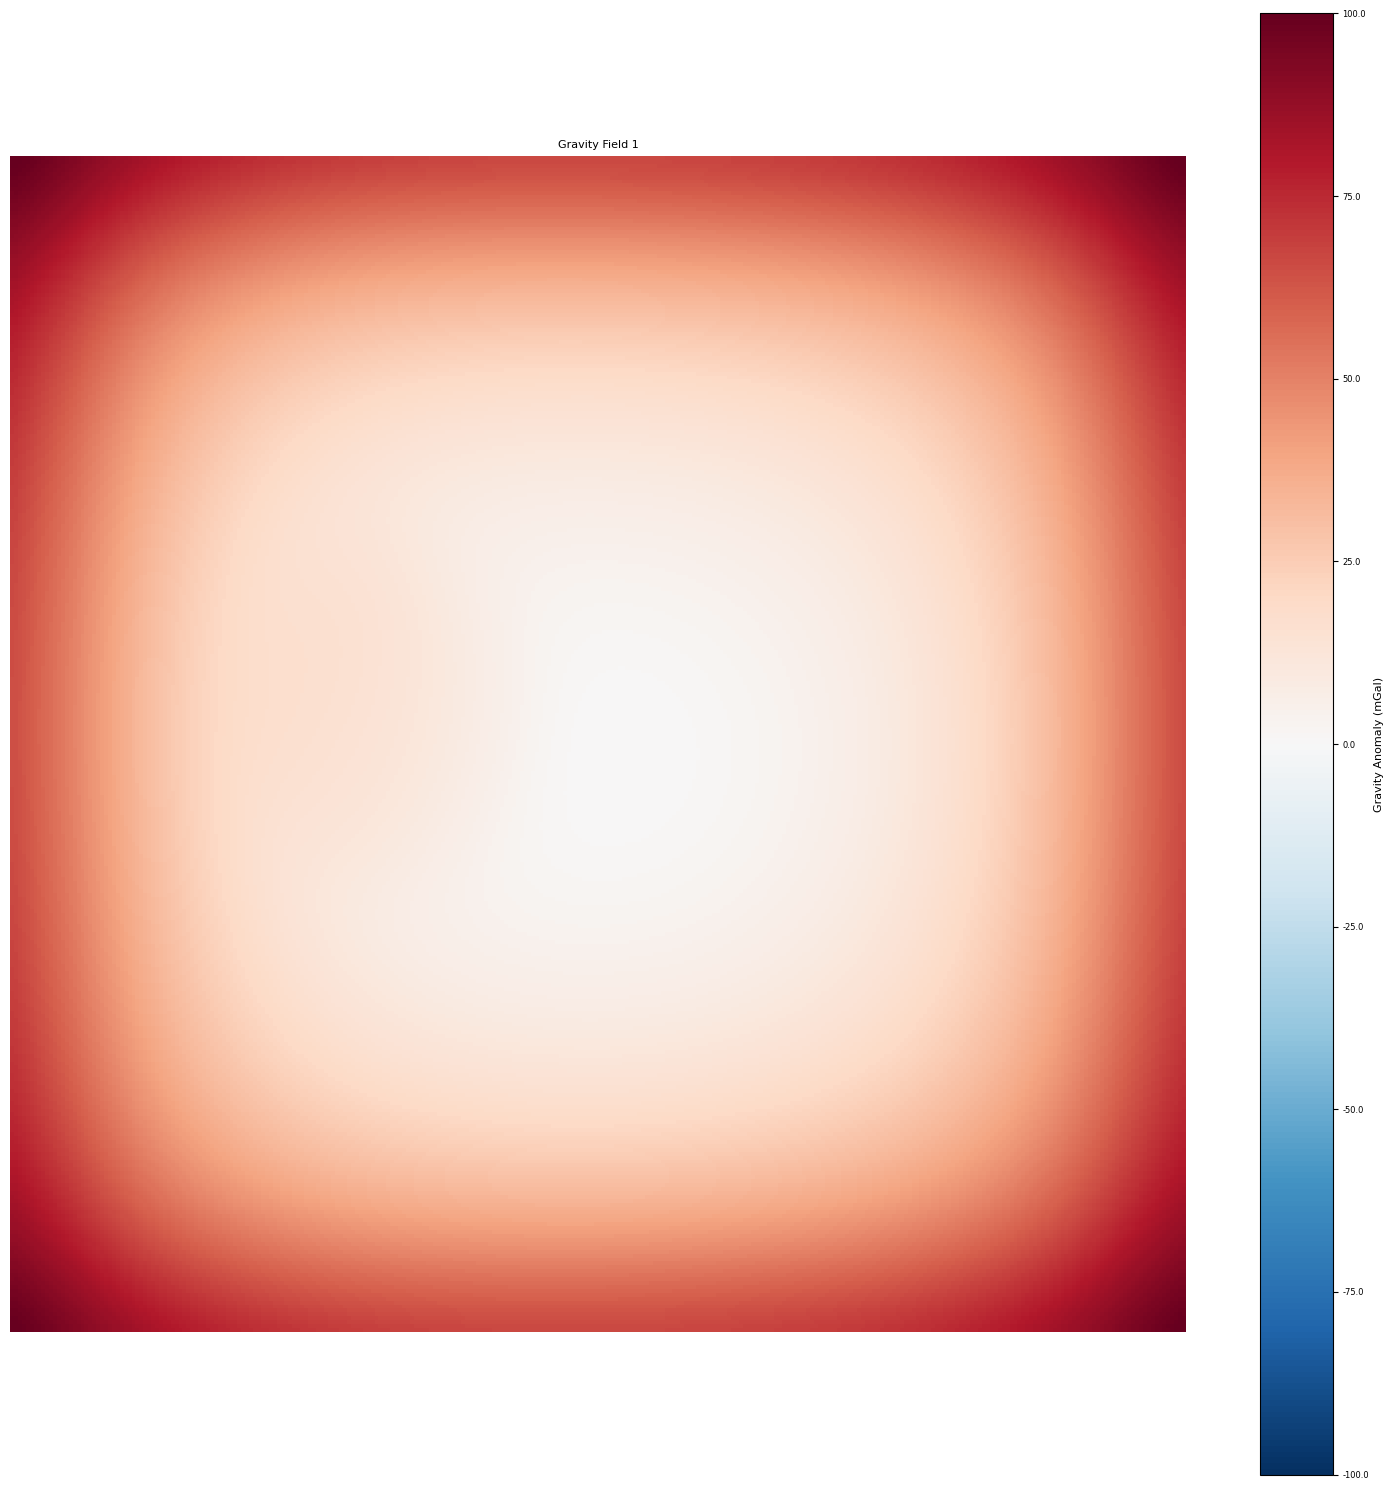

In [ ]:
visualize_data(gravity_model[None,...],'gravity',save_path=f_path+"gravity_model_visualization_seed0.pdf")

In [ ]:
#@title interactive 3D visulization with py for-loop

def visualize_isosurfaces(velocity_model):
    """Create interactive 3D visualization using isosurfaces"""
    import plotly.graph_objects as go
    import numpy as np

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create a figure
    fig = go.Figure()

    # Calculate values for isosurfaces
    v_min = vel.min()
    v_max = vel.max()
    values = np.linspace(v_min + 0.2*(v_max-v_min), v_max - 0.2*(v_max-v_min), 3)

    # Add isosurfaces
    for i, value in enumerate(values):
        opacity = 0.3 if i == 1 else 0.2

        fig.add_trace(go.Isosurface(
            x=np.arange(nx).reshape(nx, 1, 1).repeat(ny, axis=1).repeat(nz, axis=2).flatten(),
            y=np.arange(ny).reshape(1, ny, 1).repeat(nx, axis=0).repeat(nz, axis=2).flatten(),
            z=np.arange(nz).reshape(1, 1, nz).repeat(nx, axis=0).repeat(ny, axis=1).flatten(),
            value=vel.flatten(),
            isomin=value,
            isomax=value,
            opacity=opacity,
            surface_count=1,
            colorscale='Jet',
            caps=dict(x={'show': False}, y={'show': False}, z={'show': False})
        ))

    # Add slices
    mid_x, mid_y, mid_z = nx//2, ny//2, nz//2

    # X slice
    fig.add_trace(go.Volume(
        x=np.ones(ny*nz)*mid_x,
        y=np.arange(ny).reshape(ny, 1).repeat(nz, axis=1).flatten(),
        z=np.arange(nz).reshape(1, nz).repeat(ny, axis=0).flatten(),
        value=vel[mid_x, :, :].flatten(),
        opacity=0.8,
        surface_count=1,
        colorscale='Jet'
    ))

    # Update layout
    fig.update_layout(
        title='Velocity Model - Isosurfaces and Slices',
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='data'
        ),
        width=800,
        height=800
    )

    fig.show()
    return fig


# Install plotly if not already installed
# !pip install plotly

# Visualize the model
visualize_isosurfaces(gravity_model)


<ipython-input-15-551341c1f299>:70: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout(rect=[0, 0, 0.9, 1])


Figure saved as '/content/drive/MyDrive/DiTing2.0/velocity_visualization_seed0.pdf'


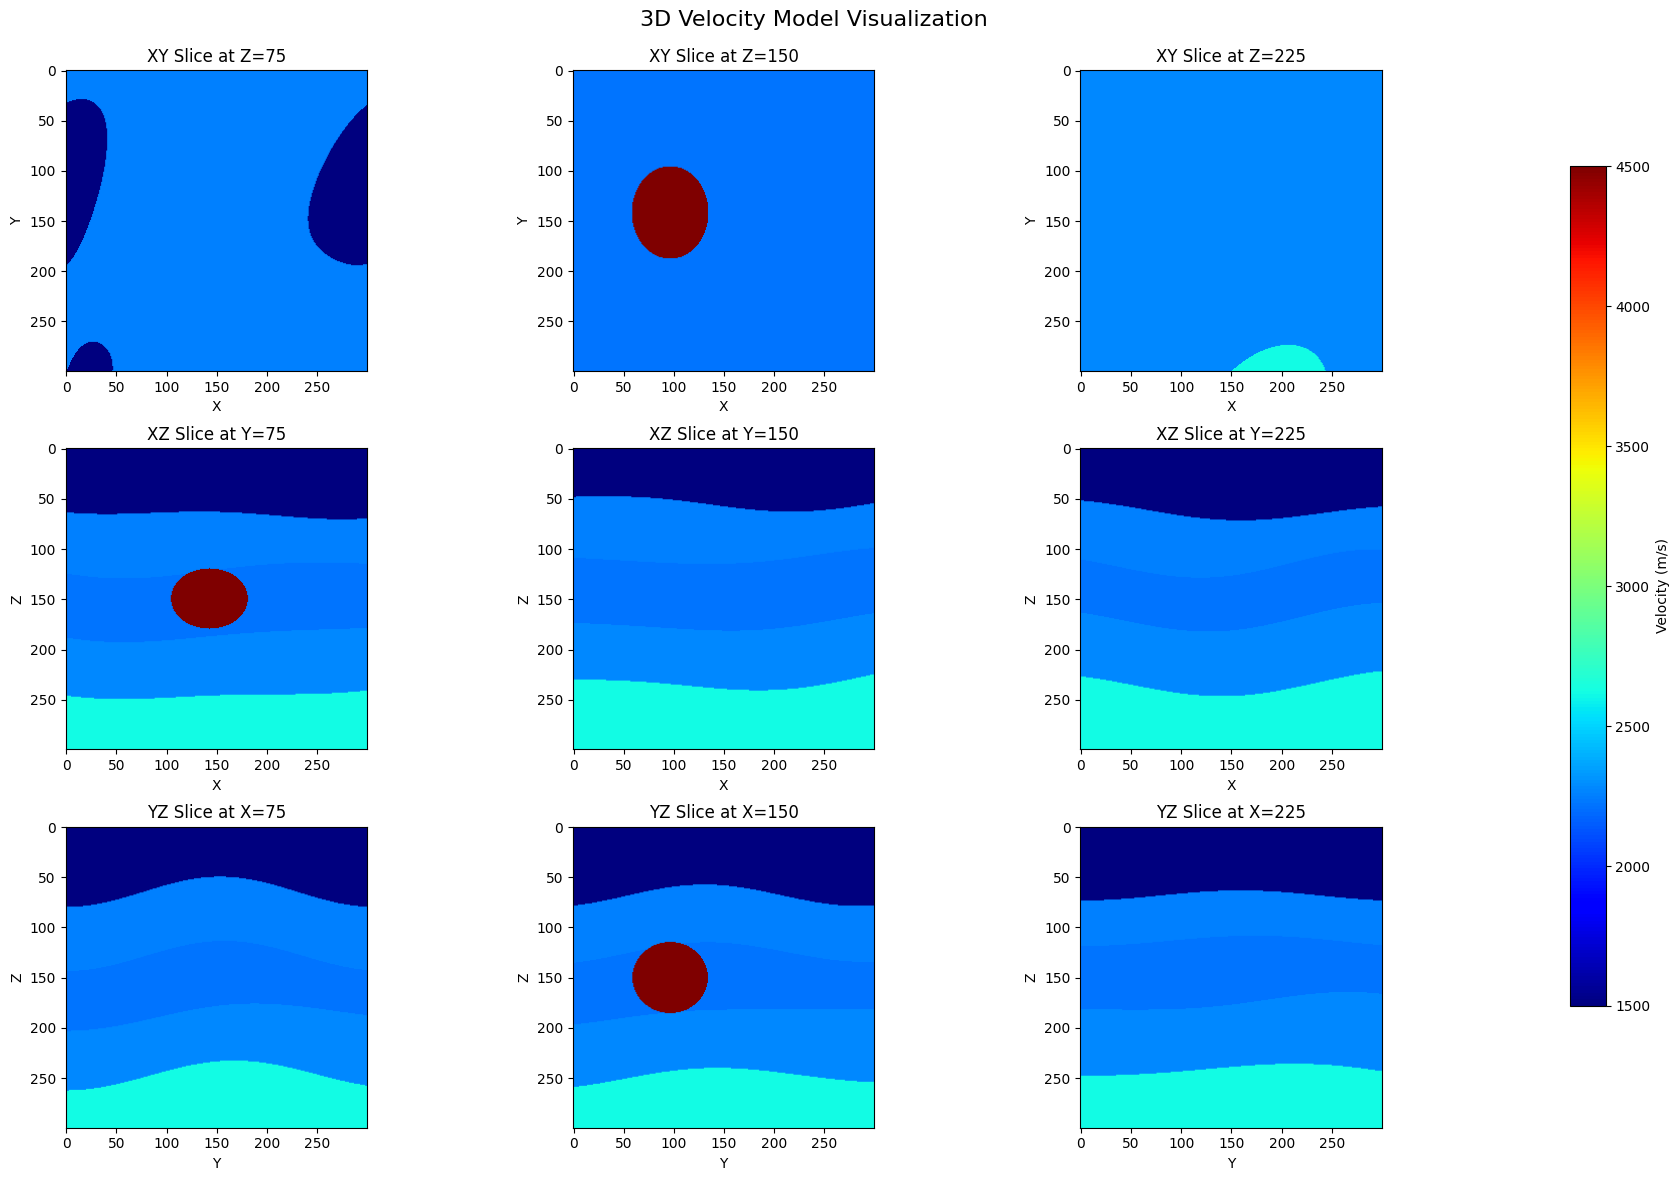

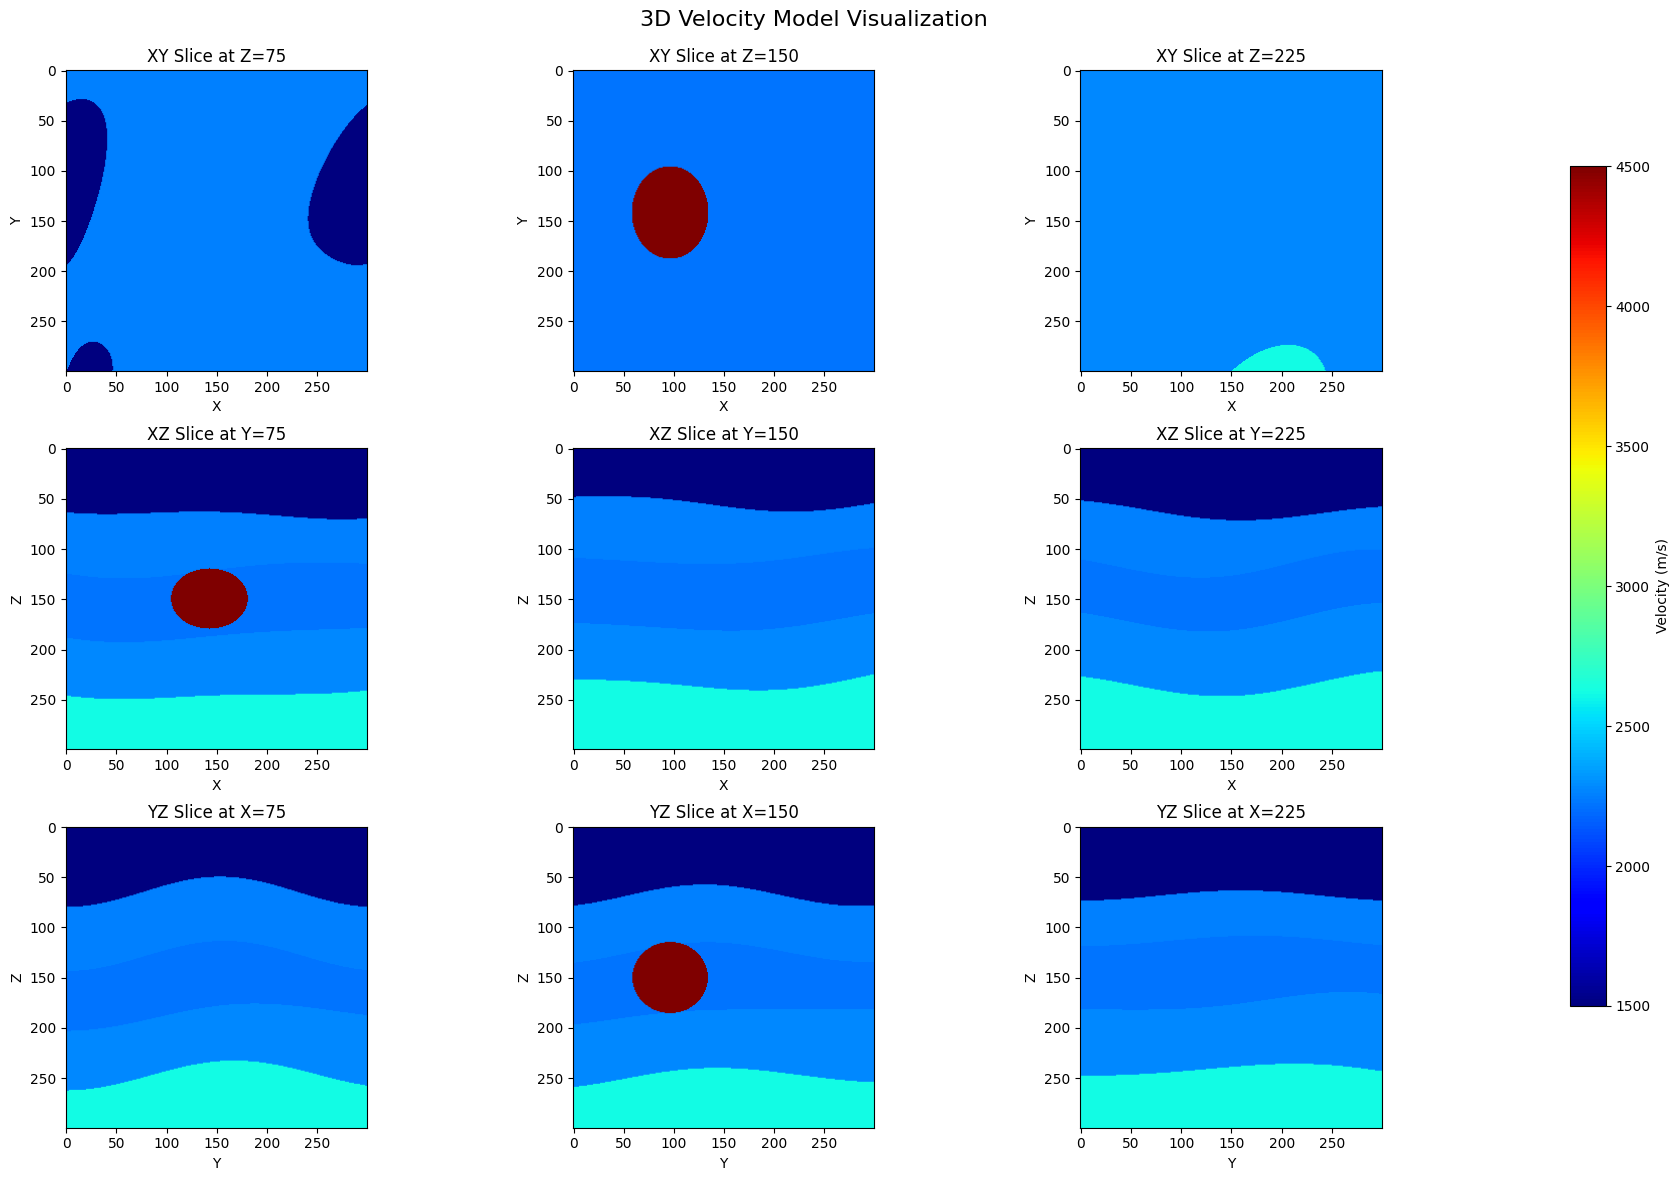

In [ ]:
#@title 3D velocity model visulization
import matplotlib.pyplot as plt
import numpy as np

def visualize_model_comprehensive(velocity_model, save_pdf=False, filename=f_path+"gravity_model_visualization_seed0.pdf"):
    """
    Comprehensive visualization of 3D velocity model with multiple views

    Parameters:
    -----------
    velocity_model : torch.Tensor
        The 3D velocity model to visualize
    save_pdf : bool, optional
        Whether to save the figure as PDF (default: False)
    filename : str, optional
        Name of the PDF file to save (default: "velocity_model_visualization.pdf")

    Returns:
    --------
    fig : matplotlib.figure.Figure
        The figure object
    """
    import matplotlib.pyplot as plt
    import numpy as np
    from matplotlib.colors import Normalize

    # Convert to numpy
    vel = velocity_model.cpu().numpy()
    nx, ny, nz = vel.shape

    # Create figure
    fig = plt.figure(figsize=(18, 12))

    # Define colormap and normalization
    cmap = plt.cm.jet
    norm = Normalize(vmin=vel.min(), vmax=vel.max())

    # 1. XY slices at different depths
    depths = [nz//4, nz//2, 3*nz//4]
    for i, depth in enumerate(depths):
        ax = fig.add_subplot(3, 3, i+1)
        im = ax.imshow(vel[:, :, depth], cmap=cmap, norm=norm)
        ax.set_title(f'XY Slice at Z={depth}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')

    # 2. XZ slices at different Y positions
    y_positions = [ny//4, ny//2, 3*ny//4]
    for i, y_pos in enumerate(y_positions):
        ax = fig.add_subplot(3, 3, i+4)
        im = ax.imshow(vel[:, y_pos, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'XZ Slice at Y={y_pos}')
        ax.set_xlabel('X')
        ax.set_ylabel('Z')

    # 3. YZ slices at different X positions
    x_positions = [nx//4, nx//2, 3*nx//4]
    for i, x_pos in enumerate(x_positions):
        ax = fig.add_subplot(3, 3, i+7)
        im = ax.imshow(vel[x_pos, :, :].T, cmap=cmap, norm=norm)
        ax.set_title(f'YZ Slice at X={x_pos}')
        ax.set_xlabel('Y')
        ax.set_ylabel('Z')

    # Add colorbar
    cbar_ax = fig.add_axes([0.92, 0.15, 0.02, 0.7])
    cbar = fig.colorbar(im, cax=cbar_ax)
    cbar.set_label('Velocity (m/s)')

    plt.tight_layout(rect=[0, 0, 0.9, 1])
    plt.suptitle('3D Velocity Model Visualization', fontsize=16)
    plt.subplots_adjust(top=0.93)

    # Save figure as PDF if requested
    if save_pdf:
        plt.savefig(filename, format='pdf', bbox_inches='tight', dpi=300)
        print(f"Figure saved as '{filename}'")

    plt.show()

    return fig


# Visualize the model
visualize_model_comprehensive(velocity_model,save_pdf=True,filename=f_path+"velocity_visualization_seed0.pdf")

